# Codage canal

In [1]:
import komm
import numpy as np
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt

## Codes & encodeur

### Code à parité (5,4)

On commence par définir les tailles des blocs du message et du code, ainsi que la matrice génératrice :

In [2]:
n, k = 5, 4
P = np.ones((k,n-k))
I = np.eye(k)
G = np.concatenate((I, P), axis=1)

print("G =")
print(G)

G =
[[1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1.]]


On définit alors un objet qui correspond au code à parité (5,4) :

In [3]:
code_parity = komm.BlockCode(generator_matrix=G)

Le résultat de `BlockCode` est un objet, nommé ici `code_parity` qui possède plusieurs méthodes, notamment celle pour coder un bloc de $k$ bits :

In [4]:
message = np.array([0, 1, 1, 0])
code = code_parity.encode(message)
print(f"Le message {message} est codé {code}")

Le message [0 1 1 0] est codé [0 1 1 0 0]


Pour coder un message plus long, on doit le découper en blocs de $k$ bits et coder chacun d'eux :

In [5]:
# Message de plus de 4 bits
message = [0, 1, 1, 0, 1, 1]
N = len(message)

# Initialisation du code
code = np.array([], dtype=np.int64)

# Scanne le message par blocs de k symboles
for i in range(0, N, k):
    
    # Bloc
    m = message[i:i+k]
    
    # Ajout éventuel de 0 si m contient moins de 4 bits
    if len(m) < k:
        z = np.zeros(k-len(m), dtype=np.int64)
        m = np.append(m, z)
        
    # Codage du bloc
    c = code_parity.encode(m)
        
    # Ajout du code
    code = np.append(code, c)
    
print("Message : ", np.array(message))
print("Code    : ", code)

Message :  [0 1 1 0 1 1]
Code    :  [0 1 1 0 0 1 1 0 0 0]


Le décodage fonctionne de façon similaire, avec la fonction `decode` :

In [6]:
for code in [ np.array([0, 1, 1, 0, 0]), np.array([0, 1, 1, 0, 1]) ]:
    message = code_parity.decode(code)
    print(f"Le code {code} est décodé en {message}")

Le code [0 1 1 0 0] est décodé en [0 1 1 0]
Le code [0 1 1 0 1] est décodé en [1 1 1 0]



### Code de Hamming (7,4)

On procède de même que pour le code précédent, sauf que cette fois il suffit de donner la valeur de $m$, qui est défini en fonction de $k=4$ et $n=7$ tel que (se référer à la documentation du module komm) :

$$
n=2m-1
\quad\text{et}\quad
k=2m-m-1.
$$

In [7]:
m = 3
code_hamming = komm.HammingCode(m)

### Code convolutif

Là encore, on définit l'objet représentant le code en lui précisant les polynômes générateurs.

In [8]:
code_conv = komm.ConvolutionalCode([[0o7, 0o5]])

## Tests sur des séquences courtes

In [9]:
def encode(msg, code):
    
    # Type de code
    code_type = type(code).__name__
        
    # Codage dans le cas d'un code en bloc
    if code_type == "BlockCode" or code_type == "HammingCode":
        
        # Message codé
        enc = np.array([], dtype=np.int64)
        
        # Taille des blocs
        k = code.dimension
        
        # Scanne le message par blocs de k symboles
        for i in range(0, len(msg), k):

            # Bloc
            m = msg[i:i+k]

            # Ajout éventuel de 0
            if len(m) < k:
                z = np.zeros(k-len(m), dtype=np.int64)
                m = np.append(m, z)
            
            c = code.encode(m)
        
            # Ajout du code
            enc = np.append(enc, c)
    
    # Codage dans le cas d'un code convolutif
    if code_type == "ConvolutionalCode":
        conv_encoder = komm.ConvolutionalStreamEncoder(code)
        enc = conv_encoder(msg)
    
    return enc

In [10]:
def decode(enc, code):
    
    # Type de code
    code_type = type(code).__name__
    
    # Décodage dans le cas d'un code en bloc
    if code_type == "BlockCode" or code_type == "HammingCode":
    
        # Message décodé
        dec = np.array([], dtype=np.int64)
        
        # Taille des blocs
        n = code.dimension + code.redundancy
        
        # Scanne le code par blocs de n symboles
        for i in range(0, len(enc), n):
            
            # Bloc
            c = enc[i:i+n]
            d = code.decode(c)
        
            # Ajout du code
            dec = np.append(dec, d)
    
    # Décodage dans le cas d'un code convolutif
    if code_type == "ConvolutionalCode":
        conv_decoder = komm.ConvolutionalStreamDecoder(code, traceback_length=10)
        dec = conv_decoder(enc)
    
    return dec

In [11]:
N = 20
msg = np.random.randint(2, size=N)
print("Message :       ", msg)
print()

print("Code à parité (5,4)")
encp = encode(msg, code_parity)
print("Message codé :  ", encp)
decp = decode(encp, code_parity)
print("Message décodé :", decp)
print()

print("Code de Hamming (7,4) :")
ench = encode(msg, code_hamming)
print("Message codé :  ", ench)
dech = decode(ench, code_hamming)
print("Message décodé :", dech)
print()

print("Code convolutif :")
# Rajoute des zéros en fin de message pour vider le buffer
m = np.append(msg, np.zeros(10))
encc = encode(m, code_conv)
print("Message codé :  ", encc)
decc = decode(encc, code_conv)
decc = decc[10:] # Décalage de traceback_length
print("Message décodé :", decc)
print()

Message :        [1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1]

Code à parité (5,4)
Message codé :   [1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0]
Message décodé : [1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1]

Code de Hamming (7,4) :
Message codé :   [1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1]
Message décodé : [1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1]

Code convolutif :
Message codé :   [1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1
 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Message décodé : [1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1]



## Test sur séquence longue

Une p'tite boucle sur plusieurs valeurs de $\alpha$, au sein de laquelle une grande séquence binaire est générée, puis codée, transmise sur le canal binaire symétrique et décodée, avant de calculer finalement le pourcentage d'erreur.

In [12]:
# Print iterations progress
# https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [13]:
def myplot(alpha, e0, ep, eh, ec):
    """Mon affichage"""
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.plot(alpha, e0, label="Sans code")
    ax.plot(alpha, ep, label="Code à parité")
    ax.plot(alpha, eh, label="Hamming")
    ax.plot(alpha, ec, label="convolutif")
    ax.set_xlabel("Probabilité d'erreur")
    ax.set_ylabel("Taux d'erreur par bit")
    ax.legend()
    ax.grid()
    ax.axis('equal')
    plt.show()

In [14]:
def mycompute(alpha):
    
    """Calcul des erreurs pour les différents codes"""
    
    I = len(alpha)

    e0 = np.array([])
    ep = np.array([])
    eh = np.array([])
    ec = np.array([])

    printProgressBar(0, I)

    for i, a in enumerate(alpha):

        printProgressBar(i+1, I)

        # Message
        msg = np.random.randint(2, size=N)
        
        # Codages
        cp = encode(msg, code_parity)
        ch = encode(msg, code_hamming)
        mc = np.append(msg, np.zeros(10))
        cc = encode(mc, code_conv)

        # Canal binaire symétrique
        bsc = komm.BinarySymmetricChannel(a)
        r0 = bsc(msg)
        rp = bsc(cp)
        rh = bsc(ch)
        rc = bsc(cc)

        # Décodages
        dp = decode(rp, code_parity)
        dh = decode(rh, code_hamming)
        dc = decode(rc, code_conv)
        dc = dc[10:] # Décalage de traceback_length

        # Nombre d'erreurs
        e0 = np.append(e0, hamming(msg,r0))
        ep = np.append(ep, hamming(msg,dp))
        eh = np.append(eh, hamming(msg,dh))
        ec = np.append(ec, hamming(msg,dc))
        
    return e0, ep, eh, ec

In [15]:
# Taille du message (multiple de 4 bits)
N = 4*2000

Affichage grossier entre 0 et 50 % :

In [16]:
alpha = np.arange(.00, .50, .05)
e0, ep, eh, ec = mycompute(alpha)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


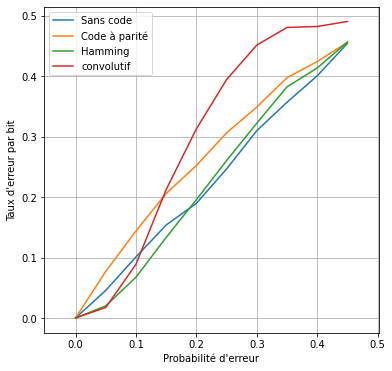

In [17]:
myplot(alpha, e0, ep, eh, ec)

Affichage fin entre 0 et 5 % :

In [18]:
alpha = np.arange(.00, .05, .001)
e0, ep, eh, ec = mycompute(alpha)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


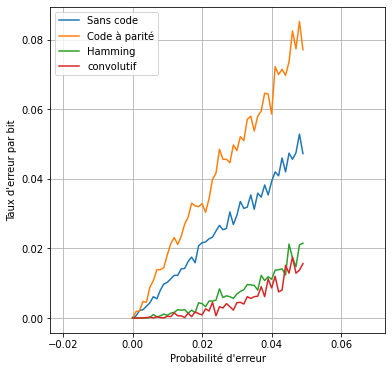

In [19]:
myplot(alpha, e0, ep, eh, ec)

Bien évidemment, quel que soit le codage utilisé, le taux d'erreur augmente avec la probabilité d'erreur sur le canal.
Néanmoins, l'utilisation d'un codage canal permet de diminuer le taux d'erreur.

Le **code de Hamming** et le **code convolutif**,
puisqu'ils sont capables de détecter et de corriger des erreurs, permettent de réduire les erreurs de transmission.

En revanche, ce n'est pas le cas du **code à parité** qui produit plus d'erreurs que le canal n'en introduit.
La raison est que le code à parité est capable de détecter des erreurs de transmission, mais pas de les corriger.
Comme la transmission se fait ici en simplex, le récepteur, même s'il a détecté une erreur,
n'est pas en mesure de demander à l'émetteur de renvoyer le message transmis.
Par ailleurs, l'implémentation du décodage de la fonction `komm.BlockCode` peut introduire des erreurs, comme dans l'exemple ci-dessous :

In [20]:
m = np.array([0, 1, 1, 0])
c = code_parity.encode(m)
r = c + np.array([0, 0, 0, 0, 1])
d = code_parity.decode(r)

print(f"Message        : {m}")
print(f"Message codé   : {c}")
print(f"Message reçu   : {r}  (erreur de transmission sur le bit de parité)")
print(f"Message décodé : {d}    (introduction d'une erreur dans le message)")

Message        : [0 1 1 0]
Message codé   : [0 1 1 0 0]
Message reçu   : [0 1 1 0 1]  (erreur de transmission sur le bit de parité)
Message décodé : [1 1 1 0]    (introduction d'une erreur dans le message)
